Notebook looking at distance metrics between clusters

In [2]:
import anndata as ad
import pandas as pd
import scanpy as sc
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [3]:
# Load sequencing data
seqData = ad.read_h5ad("../data/rnaseq_AIT17.2_2022-12-15_12-00-00/rnaseq/processed.U19_TH-EPI.postQC.h5ad")

In [4]:
# Subset to anterior thalamic nuclei (ATN). Each nucleus is composed of two clusters
atnGroup = ["1095 AD Serpinb7 Glut", "1096 AD Serpinb7 Glut","1097 AV Col27a1 Glut","1098 AV Col27a1 Glut","1169 TH Prkcd Grin2c Glut_9", "1171 TH Prkcd Grin2c Glut_9"]
atnData = seqData[seqData.obs["cluster_label"].isin(atnGroup)]

In [5]:
# Compare clusters pairwise
for cl in atnGroup:
    sc.tl.rank_genes_groups(atnData,groupby="cluster_label",reference = cl, pts = True,key_added=cl)

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [61]:
def getDEGs(seqData,refGroup, degGroups = False, nGenes = 1,):
    # Function to select a requested number of genes from a previously computed scanpy "rank_gene_groups" object
    
    # Check that requested reference groups are present within the provided annData object.
    seqGroups = set(seqData.uns.keys())
    if not set(refGroup).issubset(seqGroups):
        raise Exception("Could not find keys corresponding to requested reference groups. Run sc.tl.rank_gene_groups with the proper keys added.")
    
    # Take the top nGenes from each pairwise comparison
    degs = []
    for ref in refGroup:
        # Pull from specific groups if requested, otherwise all pairwise combinations
        if degGroups:
            useGroups = set(degGroups) - set([ref])
            for cl in useGroups:
                degs.extend(seqData.uns[ref]["names"][cl][0:nGenes])
        
        # Iterate through all groups if requested
        else:
            for cl in seqData.uns[ref]["names"].dtype.names:
                degs.extend(seqData.uns[ref]["names"][cl][0:nGenes])
            
    # Make genes unique
    degs = list(np.unique(degs))
    return degs

In [7]:
def calcSil(seqData,degs,group = "Level2_id_label",metric = "l1",showPrint = True, showPlot = True):
    # Function to calculate silhouette coefficient for each cell using a given feature set "degs". Prints mean coefficient and/or plots histograms for each group.
    
    x = seqData[:,degs].X.A
    y = seqData.obs[group].to_numpy()
    z = metrics.silhouette_samples(x, y, metric=metric,n_jobs = -1)
    
    if showPrint:
        for cl in np.unique(y):
            print(cl + ': ' + str(np.mean(z[y == cl])))
        
    if showPlot:
        for cl in np.unique(y):
            plt.hist(z[y == cl],bins=np.linspace(-1,1,100), edgecolor = 'black', alpha = .6, label = cl, density = True);
        plt.legend()
        
    return z

### Compare subclass distances

nGenes = 5
65_AD Serpinb7 Glut: 0.5815875
66_AV Col27a1 Glut: 0.20651524
69_TH Prkcd Grin2c Glut: 0.40010977
nGenes = 10
65_AD Serpinb7 Glut: 0.5260684
66_AV Col27a1 Glut: 0.22134829
69_TH Prkcd Grin2c Glut: 0.3689856
nGenes = 25
65_AD Serpinb7 Glut: 0.4600216
66_AV Col27a1 Glut: 0.19876455
69_TH Prkcd Grin2c Glut: 0.30483866


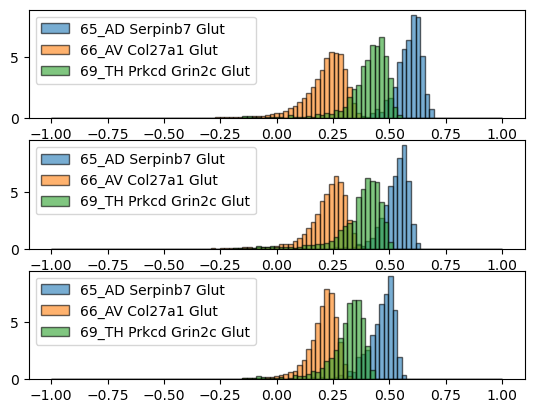

In [27]:
# Look at silhouette coefficients for increasing numbers of DEGs
for count, genes in enumerate([5,10,25]):
    degs = getDEGs(atnData,atnGroup,nGenes = genes)
    print("nGenes = " + str(genes))
    plt.subplot(3,1,count+1)
    calcSil(atnData,degs)

Increasing feature set reduces silhouette scores, even when adding differentially expressed genes. Maximal silhouette score is for the single most differentially expressed gene.

### Compare intra subclass cluster silhouette distances

nGenes = 1
1095 AD Serpinb7 Glut: 0.21487708
1096 AD Serpinb7 Glut: 0.7464766
nGenes = 10
1095 AD Serpinb7 Glut: 0.15442911
1096 AD Serpinb7 Glut: 0.64244854
nGenes = 25
1095 AD Serpinb7 Glut: 0.11281317
1096 AD Serpinb7 Glut: 0.5978831


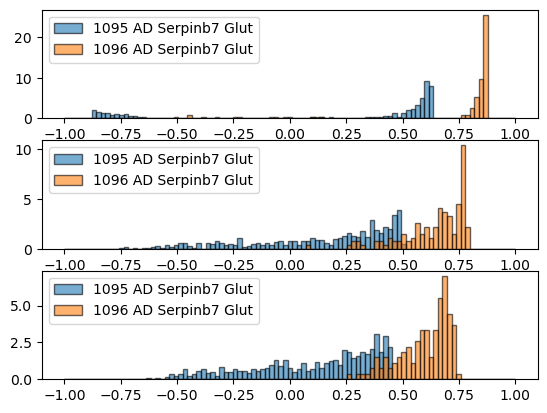

In [74]:
# First look at AD clusters
usePair = atnGroup[0:2]
# Subset to AD data
pairData = atnData[atnData.obs["cluster_label"].isin(usePair)]


# Look at silhouette coefficients for increasing numbers of DEGs
for count, genes in enumerate([1,10,25]):
    degs = getDEGs(pairData,usePair,degGroups = usePair,nGenes = genes)
    print("nGenes = " + str(genes))
    plt.subplot(3,1,count+1)
    calcSil(pairData,degs,group="cluster_label")

nGenes = 1
1097 AV Col27a1 Glut: 0.46426648
1098 AV Col27a1 Glut: 0.578712
nGenes = 10
1097 AV Col27a1 Glut: 0.517997
1098 AV Col27a1 Glut: 0.24171658
nGenes = 25
1097 AV Col27a1 Glut: 0.41126934
1098 AV Col27a1 Glut: 0.23193473


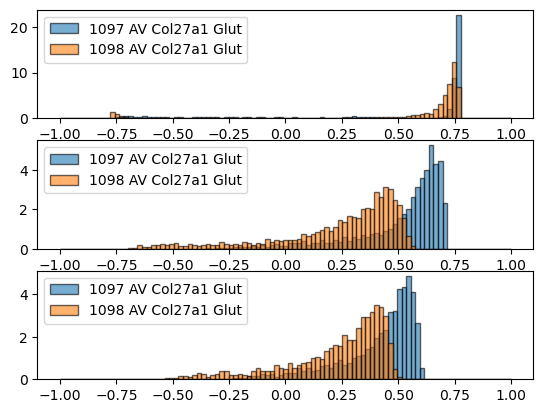

In [77]:
# First look at AV clusters
usePair = atnGroup[2:4]
# Subset to AV data
pairData = atnData[atnData.obs["cluster_label"].isin(usePair)]


# Look at silhouette coefficients for increasing numbers of DEGs
for count, genes in enumerate([1,10,25]):
    degs = getDEGs(pairData,usePair,degGroups = usePair,nGenes = genes)
    print("nGenes = " + str(genes))
    plt.subplot(3,1,count+1)
    calcSil(pairData,degs,group="cluster_label")

nGenes = 1
1169 TH Prkcd Grin2c Glut_9: 0.061045066
1171 TH Prkcd Grin2c Glut_9: 0.56300586
nGenes = 10
1169 TH Prkcd Grin2c Glut_9: 0.21704485
1171 TH Prkcd Grin2c Glut_9: 0.38789895
nGenes = 25
1169 TH Prkcd Grin2c Glut_9: 0.19428587
1171 TH Prkcd Grin2c Glut_9: 0.301733


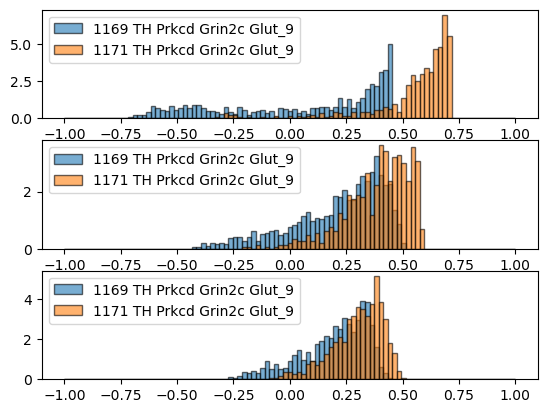

In [78]:
# First look at AM clusters
usePair = atnGroup[4:6]
# Subset to AM data
pairData = atnData[atnData.obs["cluster_label"].isin(usePair)]


# Look at silhouette coefficients for increasing numbers of DEGs
for count, genes in enumerate([1,10,25]):
    degs = getDEGs(pairData,usePair,degGroups = usePair,nGenes = genes)
    print("nGenes = " + str(genes))
    plt.subplot(3,1,count+1)
    calcSil(pairData,degs,group="cluster_label")

In [6]:
for cl in np.unique(y):
    print(cl + ': ' + str(np.mean(z[y == cl])))

65_AD Serpinb7 Glut: 0.7526973
66_AV Col27a1 Glut: 0.45419627
69_TH Prkcd Grin2c Glut: 0.5547062


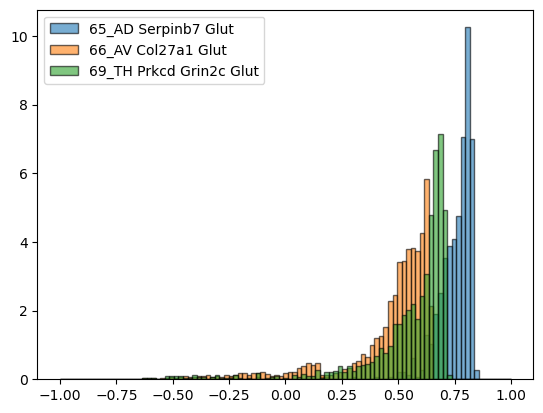

In [7]:
for cl in np.unique(y):
    plt.hist(z[y == cl],bins=np.linspace(-1,1,100), edgecolor = 'black', alpha = .6, label = cl, density = True);
    
plt.legend()

1095 AD Serpinb7 Glut: 0.11907628
1096 AD Serpinb7 Glut: -0.0010499918
1097 AV Col27a1 Glut: 0.16247135
1098 AV Col27a1 Glut: -0.25884324
1169 TH Prkcd Grin2c Glut_9: -0.0935531
1171 TH Prkcd Grin2c Glut_9: 0.08066783


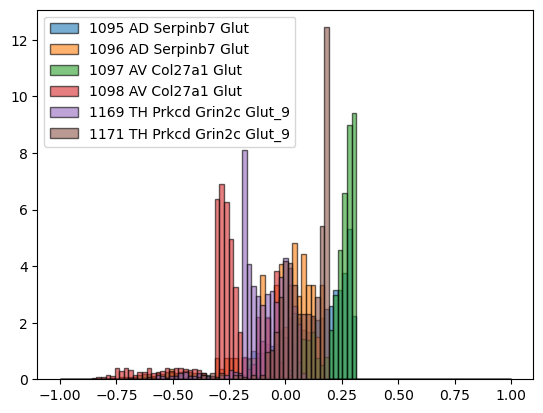

In [46]:
degs = ["C1ql2","Foxp1","Itga4"]
# Subset to top nGenes, compute silhouette samples
x = atnData[:,degs].X.A
y = atnData.obs["cluster_label"].to_numpy()
z = metrics.silhouette_samples(x, y, metric='l1',n_jobs = -1)

for cl in np.unique(y):
    print(cl + ': ' + str(np.mean(z[y == cl])))
    
for cl in np.unique(y):
    plt.hist(z[y == cl],bins=np.linspace(-1,1,100), edgecolor = 'black', alpha = .6, label = cl, density = True);
    
plt.legend()

In [36]:
# Take the top nGenes from each pairwise comparison
nGenes = 1
degs = []
for ref in atnGroup:
    for cl in atnData.uns[ref]["names"].dtype.names:
        degs.extend(atnData.uns[ref]["names"][cl][0:nGenes])
        
# Subset to top nGenes, compute silhouette samples
x = atnData[:,degs].X.A
y = atnData.obs["Level2_id_label"].to_numpy()
z = metrics.silhouette_samples(x, y, metric='l1',n_jobs = -1)

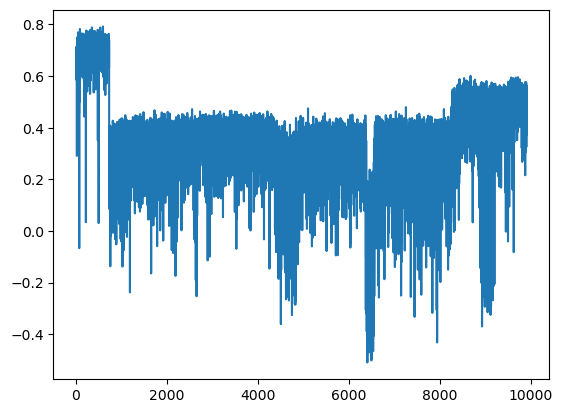

In [30]:
x = atnData[:,degs].X.A
y = atnData.obs["Level2_id_label"].to_numpy()
z = metrics.silhouette_samples(x, y, metric='l1',n_jobs = -1)

In [3]:
atnGroup = ["1095 AD Serpinb7 Glut", "1096 AD Serpinb7 Glut","1097 AV Col27a1 Glut","1098 AV Col27a1 Glut"]
atnData = seqData[seqData.obs["cluster_label"].isin(atnGroup)]

In [18]:
x = atnData.X.A
y = atnData.obs["Level2_id_label"]

In [19]:
metrics.silhouette_score(x, y, metric='l1')

0.0479029747104224

In [20]:
# n_jobs = -1 # Use all cores

In [22]:
degs = ["C1ql2","Npsr1"]
# degs = ["C1ql2","Npsr1","Itga4","Hcn1","Ramp3"]

In [42]:
x = atnData[0:1500,degs].X.A
y = atnData[0:1500,:].obs["Level2_id_label"].to_numpy()
metrics.silhouette_score(x, y, metric='l1',n_jobs = -1)

In [43]:
unique, counts = np.unique(y, return_counts=True)
print(counts)

[729 771]


In [45]:
x = atnData[:,degs].X.A
y = atnData.obs["Level2_id_label"].to_numpy()
metrics.silhouette_score(x, y, metric='l1',n_jobs = -1)

0.6763608

In [47]:
degs = ["C1ql2","Npsr1","Itga4","Hcn1"]
x = atnData[:,degs].X.A
y = atnData.obs["Level2_id_label"].to_numpy()
metrics.silhouette_score(x, y, metric='l1',n_jobs = -1)

0.74533695

In [72]:
degs = list(atnData.var_names[0:500])
degs.append('C1ql2')
degs.append('Npsr1')
x = atnData[:,degs].X.A
y = atnData.obs["Level2_id_label"].to_numpy()
metrics.silhouette_score(x, y, metric='l1',n_jobs = -1)

0.0608668

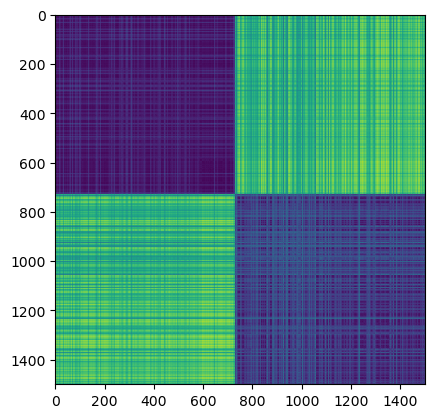

In [62]:
degs = ["C1ql2","Npsr1"]
x = atnData[0:1500,degs].X.A
y = atnData[0:1500,:].obs["Level2_id_label"].to_numpy()
z = metrics.pairwise_distances(x,metric='l1',n_jobs=-1)
plt.imshow(z)

In [28]:
# Compare clusters pairwise
for cl in atnGroup:
    sc.tl.rank_genes_groups(atnData,groupby="cluster_label",reference = cl, pts = True,key_added=cl)

In [93]:
# Take the top nGenes from each pairwise comparison
nGenes = 5
degs = []
for ref in atnGroup:
    for cl in atnData.uns[ref]["names"].dtype.names:
        degs.extend(atnData.uns[ref]["names"][cl][0:nGenes])

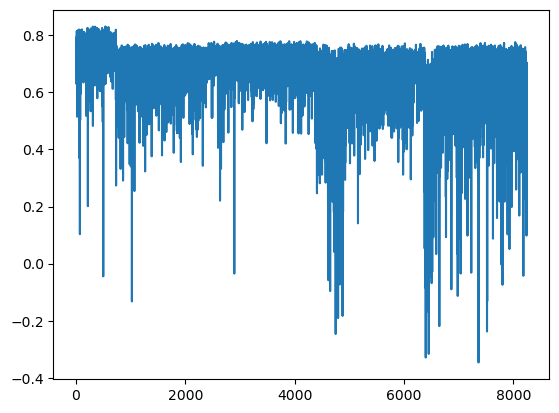

In [98]:
x = atnData[:,degs].X.A
y = atnData.obs["Level2_id_label"].to_numpy()

# x = atnData[0:1500,degs].X.A
# y = atnData[0:1500,:].obs["Level2_id_label"].to_numpy()
# y = atnData[0:1500,:].obs["cluster_label"].to_numpy()
z = metrics.silhouette_samples(x, y, metric='l1',n_jobs = -1)
plt.plot(z)